# Lightning Integration: Advanced Tutorial and Multi-GPU Automatic Support

The following notebook is equivalent to /control/Part_1_stabilize_linear_system.ipynb, but now showcasing the use of **PyTorch-Lightning** to simplify the user workflow. 

This notebook also describes how to use **multi-GPU** distributed training.

*For performance reasons, we only demonstrate single-GPU training. For a multi-GPU training example please refer to Part 6_lightning_multi_gpu.py*

**When running on Colab**: Please ensure your runtime has a GPU. Note that if using a single GPU runtime then the distributed GPU training example at the bottom of this notebook cannot be run

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"
!pip install lightning 


## Import

(The user might need to install PyTorch Lightning). If so, please run 

```
pip install lightning
```

In [1]:
import torch
import lightning.pytorch as pl

from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer, LitTrainer
from neuromancer.plot import pltCL, pltPhase
from torch.utils.data import Dataset, DataLoader




# Problem formulation

## Node and System classes

The Node class is a simple wrapper for any callable pytorch function or nn.Module which provides names for the inputs and outputs to be used in composition of a potentially cyclic computational graph. 

The Node, System and Problem formulation is exactly the same as in the original notebook *except* in how hardcoded tensors are handled in Lightning when wanting to use the GPU. The back-end will automatically handle all device management, so the user should *never* have to specify cuda() or .to(device) commands as in original PyTorch. However, hardcoded tensors need to be handled differently: 
* In the original code, tensors A and B are specified without a device. In traditional PyTorch, we would provide .to(device) in the definitions of A and B to run on desired GPU device
* In lightning, we cannot use .to(device) as this interrupts the automated GPU support. Instead, we need to use the **type_as()** functionality
* Furthermore, we need to wrap the original callable *xnext()* within a PyTorch-Lightning *LightningModule()* class

This is understandably a lot of extra overhead when using hardcoded tensors on the front end. 

For more information please see https://pytorch-lightning.readthedocs.io/en/1.4.9/advanced/multi_gpu.html

In [2]:
# Double integrator parameters
nx = 2
nu = 1
import numpy as np 

# neural control policy
mlp = blocks.MLP(nx, nu, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[20, 20, 20, 20])
policy = Node(mlp, ['X'], ['U'], name='policy')

A = torch.tensor([[1.2, 1.0],
                  [0.0, 1.0]])
B = torch.tensor([[1.0],
                  [0.5]])

# linear state space model when using CPU 
xnext = lambda x, u: x @ A.T + u @ B.T


# linear state space model when using Lightning for automated (multi) GPU support 
class XNextLightning(pl.LightningModule):
    def __init__(self):
        super().__init__()
    def forward(self, x,u): 
        A = torch.tensor([[1.2, 1.0],
                  [0.0, 1.0]]).type_as(x)

        B = torch.tensor([[1.0],
                  [0.5]]).type_as(x)
        
        return x @ A.T + u @ B.T
        
# If using GPU: 
double_integrator = Node(XNextLightning(), ['X', 'U'], ['X'], name='integrator')

# If using CPU, use this line below and uncomment it
#double_integrator = Node(xnext, ['X', 'U'], ['X'], name='integrator').to

# closed loop system definition
cl_system = System([policy, double_integrator])

# Rollout of two steps
cl_system.nsteps = 2
# cl_system.show()

# Define optimization problem
u = variable('U')
x = variable('X')
action_loss = 0.0001 * (u == 0.)^2  # control penalty

regulation_loss = 10. * (x == 0.)^2  # target position
loss = PenaltyLoss([action_loss, regulation_loss], [])
problem = Problem([cl_system], loss)

# we define optimizer specific to the policy instead of the overall problem
optimizer = torch.optim.AdamW(policy.parameters(), lr=0.001)

# Data Setup Function

We define the data_setup_function: 

In [3]:
# Training dataset generation
def data_setup_function():
    train_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='train')  # Split conditions into train and dev
    dev_data = DictDataset({'X': 3.*torch.randn(3333, 1, nx)}, name='dev')
    test_data = None
    return train_data, dev_data, test_data, 3333


# GPU Options and Set-Up

Assuming the appropriate callable (XNext_lightning) is used as the callable for the double integrator as discussed above, we can now pass in apropriate keyword arguments into our *LitTrainer* to automatically handle running on the GPU and/or multiple GPUs and distribute the training workload. 

We go over the keyword arguments below: 

#### To Run on CPU: 
* accelerator = "cpu" is all that is necessary

#### To Run on GPU: 
* accelerator = "gpu" is required 
* devices can be a list, integer, or "auto"
    * ex) [1,2,3] will distribute training over cuda:1, cuda:2, and cuda:3
    * ex) 7 will distribute training over the 7 GPUs automatically selected 
    * ex) "Auto" for automatic selection based on the chosen accelerator. We do not recommend this. 
* strategy is either "auto", "ddp" or "ddp_notebook"
    * "auto" will utilize a single GPU 
    * "ddp" will run distributed training across devices desginated under "devices" assuming len(devices) > 1. This keyword should *NOT* be used in notebooks, only scripts 
    * "ddp_notebook" is akin to "ddp" and should only be used in notebook environments
    
    

For more information please see: https://lightning.ai/docs/pytorch/stable/common/trainer.html#trainer-class-api


# Lightning Training with GPU

We define the LitTrainer and fit our problem to the data_setup_function. Note that below, we specify accelerator and strategy to run on single GPUs. We also specify the optimizer by using the custom_optimizer keyword argument. 

**Note: Running distributed training within a notebook setting (ddp_notebook strategy) may take significant setup time. It is recommended to run distributed training within a .py script and setting strategy="ddp". Nonetheless, running single and multi-GPU training is shown below**

Please run either of the training blocks, not both

In [4]:
# train with single GPU 
lit_trainer = LitTrainer(epochs=200, accelerator='gpu', strategy='auto', devices=[0], custom_optimizer=optimizer)
lit_trainer.fit(problem, data_setup_function)

# train with two GPU. 
lit_trainer = LitTrainer(epochs=200, accelerator='gpu', strategy='ddp_notebook', devices=[0,1], custom_optimizer=optimizer)
lit_trainer.fit(problem, data_setup_function)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/birm560/miniconda3/envs/neuromancer3/lib/python3.10/site-packages/lightning/pytorch/t

# Saving and Loading Problem Weights

By defauly, Problems() passed into LitTrainer (as well as base Neuromancer trainer) will automatically have the best weights at end of training, so there should be no need to manually load best_weights at the end of training.

That said, we can save and load weights as follows: 
* Set save_weights argument to True (this is default)
* Specify directory where to save weights (optional, by default is the current working directory)
* Use *load_state_dict_lightning()* function to properly ingest weights into Problem

By default, weights will be saved with the following convention: '{epoch}-{step}.ckpt', where “epoch” and “step” match the number of finished epoch and optimizer steps respectively. The weights file can be given a custom name by changing the "weight_name" argument to LiTrainer. E.g. "test_weights" will save to "test_weights.ckpt"


In [ ]:
lit_trainer = LitTrainer(epochs=200, accelerator='cpu', custom_optimizer=optimizer, weight_name='test_weights')
lit_trainer.fit(problem, data_setup_function)



#### Recreate a fresh problem and load weights: 

In [ ]:
# Double integrator parameters
nx = 2
nu = 1
import numpy as np 

# neural control policy
mlp = blocks.MLP(nx, nu, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[20, 20, 20, 20])
policy = Node(mlp, ['X'], ['U'], name='policy')

A = torch.tensor([[1.2, 1.0],
                  [0.0, 1.0]])
B = torch.tensor([[1.0],
                  [0.5]])

# linear state space model when using CPU 
xnext = lambda x, u: x @ A.T + u @ B.T


# linear state space model when using Lightning for automated (multi) GPU support 
class XNextLightning(pl.LightningModule):
    def __init__(self):
        super().__init__()
    def forward(self, x,u): 
        A = torch.tensor([[1.2, 1.0],
                  [0.0, 1.0]]).type_as(x)

        B = torch.tensor([[1.0],
                  [0.5]]).type_as(x)
        
        return x @ A.T + u @ B.T
        
# If using GPU: 
double_integrator = Node(XNextLightning(), ['X', 'U'], ['X'], name='integrator')

# If using CPU, use this line below and uncomment it
#double_integrator = Node(xnext, ['X', 'U'], ['X'], name='integrator').to

# closed loop system definition
cl_system = System([policy, double_integrator])

# Rollout of two steps
cl_system.nsteps = 2
# cl_system.show()

# Define optimization problem
u = variable('U')
x = variable('X')
action_loss = 0.0001 * (u == 0.)^2  # control penalty

regulation_loss = 10. * (x == 0.)^2  # target position
loss = PenaltyLoss([action_loss, regulation_loss], [])
problem = Problem([cl_system], loss)

# we define optimizer specific to the policy instead of the overall problem
optimizer = torch.optim.AdamW(policy.parameters(), lr=0.001)

#### Load weights

In [ ]:
from neuromancer.utils import load_state_dict_lightning
load_state_dict_lightning(problem, 'test_weights.ckpt')

# After Training

Like before, we can now use our trained problem/system


# Evaluate best model on a system rollout 


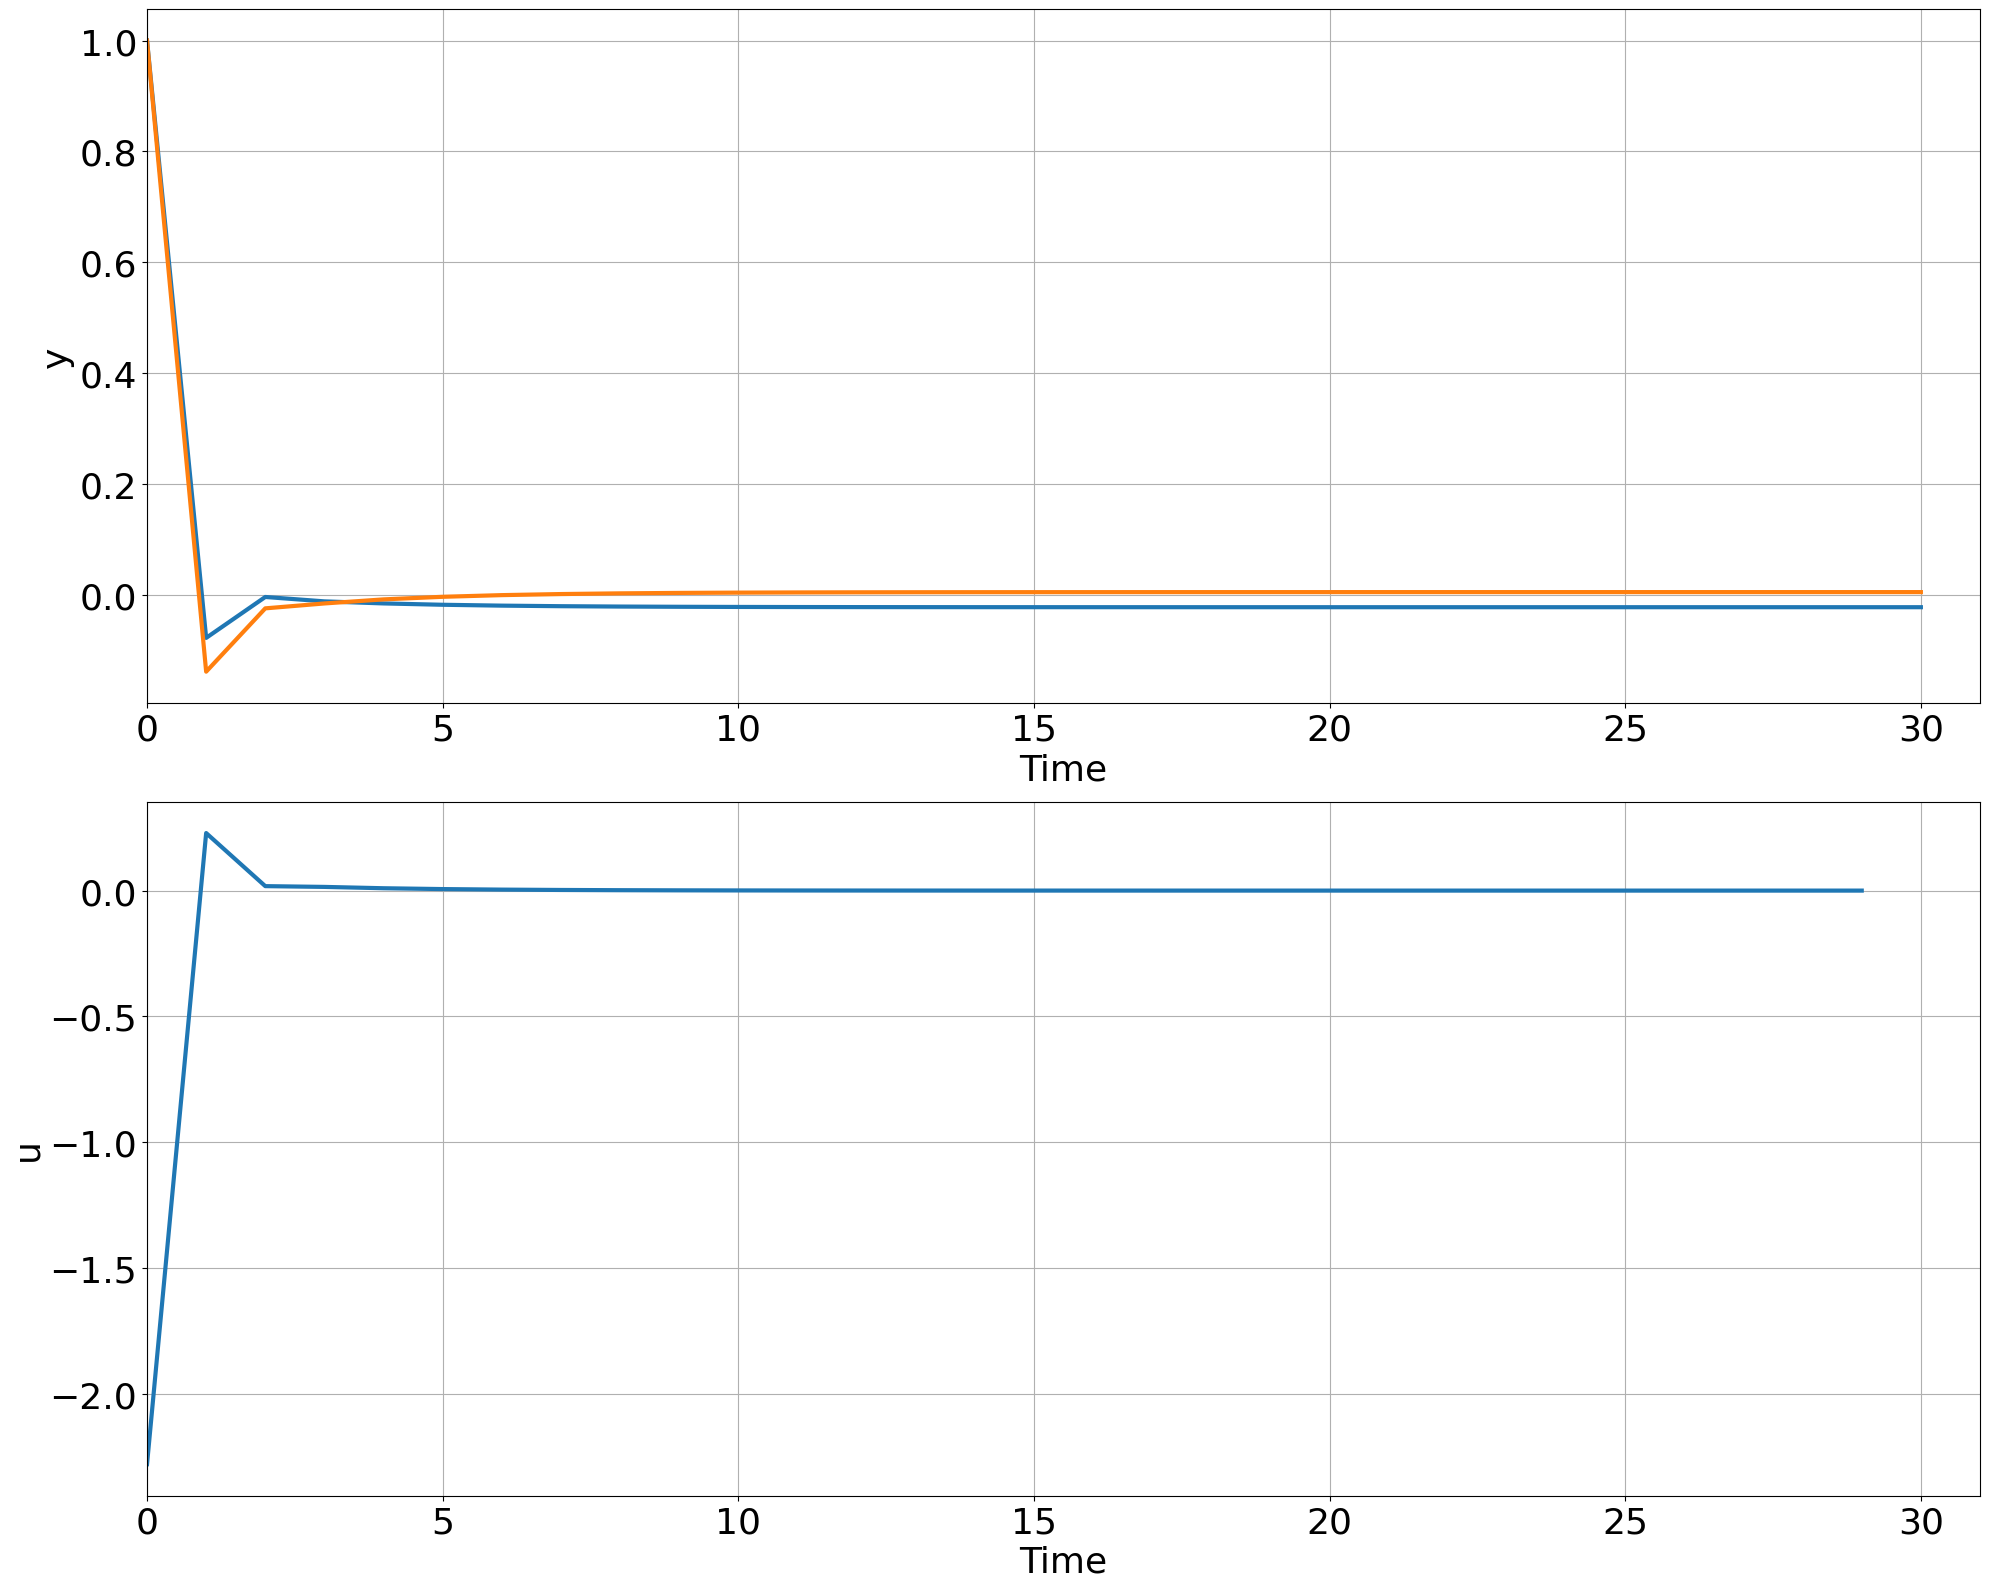

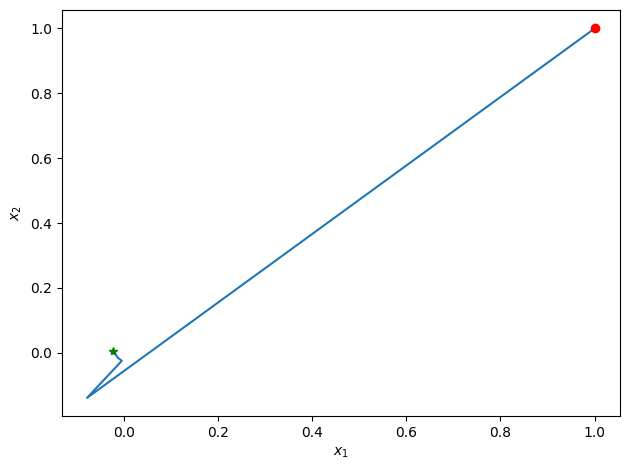

<Figure size 640x480 with 0 Axes>

In [8]:
# Test best model with prediction horizon of 50

data = {'X': torch.ones(1, 1, nx, dtype=torch.float32)}
nsteps = 30
cl_system.nsteps = nsteps
trajectories = cl_system(data)
pltCL(Y=trajectories['X'].detach().reshape(nsteps+1, 2), U=trajectories['U'].detach().reshape(nsteps, 1), figname='cl.png')
pltPhase(X=trajectories['X'].detach().reshape(nsteps+1, 2), figname='phase.png')